In [19]:
import numpy as np
from numpy import genfromtxt
from itertools import combinations
import torch
import math 
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%run r3b_clustering_def.ipynb
%run agglomerative_def.ipynb
%run ff_models_def.ipynb

In [2]:
def var1_agglo_edge(f_name_fn,f_name_data_test):
    #ff on false negative data
    training_data = genfromtxt(f_name_fn, delimiter=',')
    training_data[:,4] =(training_data[:,4]-np.min(training_data[:,4]))/(np.max(training_data[:,4])-np.min(training_data[:,4]))
    unique_values, continuous_numbers = np.unique(training_data[:,0], return_inverse=True)
    training_data[:,0] = continuous_numbers
    ###TODO_ rembember: if I use the new version of creating false negative data then I have to implement the following two lines!!!
    training_data[:,2] = training_data[:,2]*math.pi/180.
    training_data[:,3] = training_data[:,3]*math.pi/180.
    training_true = get_true_combinatorics(training_data)
    input_training_data = manip_data_ff(training_data,12) ##second param gives number of features
    pred_training = train_two_hidden_model(input_training_data,torch.FloatTensor(training_true),12,1000,5e-3,100)
    training_reco = get_true_reco_ene(training_data,pred_training[0].tolist(),training_true)
    #SOME PLOTTING
    foo_pred = pred_training[0]
    training_true = np.array(training_true)
    plt.hist(foo_pred[training_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
    plt.hist(foo_pred[training_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
    plt.yscale('log')
    plt.legend()

    ##run agglo model on test dataset
    data = genfromtxt(f_name_data_test, delimiter=',')
    data[:,4] = data[:,4]+4500  #this step is needed, I only want positive time values, so that I can use the time as a radius
    
    # ### structure of mydata : eventnr, energy, theta, phi, hit-time
    data = data*[1.,1.,3.14159/180,3.14159/180,1.]
    unique_values, continuous_numbers = np.unique(data[:,0], return_inverse=True)
    data[:,0] = continuous_numbers
    out_cluster_agglo = run_agglo_clustering(data,3540)
    
    agglo_true = get_true_combinatorics(data)
    agglo_reco = get_true_reco_ene(data,out_cluster_agglo,agglo_true)
    
    ## run pretrained ff on raw dataset test
    val_data = genfromtxt(f_name_data_test, delimiter=',')
    ## some data manipulation needed
    val_data[:,4] =(val_data[:,4]-np.min(val_data[:,4]))/(np.max(val_data[:,4])-np.min(val_data[:,4]))
    unique_values, continuous_numbers = np.unique(val_data[:,0], return_inverse=True)
    val_data[:,0] = continuous_numbers
    val_data[:,2] = val_data[:,2]*math.pi/180.
    val_data[:,3] = val_data[:,3]*math.pi/180.
    val_true = get_true_combinatorics(val_data)
    input_val_data = manip_data_ff(val_data,12) ##second param gives number of features
    pred_val = validate_two_hidden_model(input_val_data,torch.FloatTensor(val_true),12,1000,5e-3,100)
    val_reco = get_true_reco_ene(val_data,pred_val[0].tolist(),val_true)
    #combine the outputs of the agglo model and of the ff model and insert them into the "get_agglo_edge_ene"
    agglo_edge_val = get_agglo_edge_ene(val_data,out_cluster_agglo,pred_val[0].tolist(),val_true)
    return agglo_edge_val

In [3]:
def var2_agglo_edge(f_name_fn,f_name_data_test,precluster_fname):
    #ff on false negative data
    training_data = genfromtxt(f_name_fn, delimiter=',')
    training_data[:,4] =(training_data[:,4]-np.min(training_data[:,4]))/(np.max(training_data[:,4])-np.min(training_data[:,4]))
    unique_values, continuous_numbers = np.unique(training_data[:,0], return_inverse=True)
    training_data[:,0] = continuous_numbers
    ###TODO_ rembember: if I use the new version of creating false negative data then I have to implement the following two lines!!!
    training_data[:,2] = training_data[:,2]*math.pi/180.
    training_data[:,3] = training_data[:,3]*math.pi/180.
    training_true = get_true_combinatorics(training_data)
    input_training_data = manip_data_ff(training_data,12) ##second param gives number of features
    pred_training = train_two_hidden_model(input_training_data,torch.FloatTensor(training_true),12,1000,5e-3,100)
    training_reco = get_true_reco_ene(training_data,pred_training[0].tolist(),training_true)  

    ##run agglo model on test dataset
    data = genfromtxt(f_name_data_test, delimiter=',')
    data[:,4] = data[:,4]+4500  #this step is needed, I only want positive time values, so that I can use the time as a radius
    data = data*[1.,1.,3.14159/180,3.14159/180,1.]
    unique_values, continuous_numbers = np.unique(data[:,0], return_inverse=True)
    data[:,0] = continuous_numbers
    val_true = get_true_combinatorics(data)
    output_agglo_test = run_agglo_clustering(data,3540)
    output_agglo = get_true_reco_ene(data,output_agglo_test,val_true)
    #save merged hits to file
    write_reco_to_file_cms(data,output_agglo_test,precluster_fname)
    ### get array with true values of combinations
    test_true = get_true_combinatorics(data)

    #run trainded edge model on clustered data
    clustered_data = genfromtxt(precluster_fname, delimiter=',')
    ## some data manipulation needed
    clustered_data[:,4] =(clustered_data[:,4]-np.min(clustered_data[:,4]))/(np.max(clustered_data[:,4])-np.min(clustered_data[:,4]))
    unique_values, continuous_numbers = np.unique(clustered_data[:,0], return_inverse=True)
    clustered_data[:,0] = continuous_numbers
    clustered_data[:,2] = clustered_data[:,2]*math.pi/180.
    clustered_data[:,3] = clustered_data[:,3]*math.pi/180.

    input_test_data = manip_data_ff(clustered_data,12)
    out_test_edge = validate_two_hidden_model(input_test_data,torch.FloatTensor(test_true),12,1000,5e-3,100)

    #merge agglo + edge model
    agglo_edge_val = get_agglo_edge_ene(data,output_agglo_test,out_test_edge[0].tolist(),test_true)
    return agglo_edge_val

In [ ]:
def var1_r3b_edge(f_name_fn,f_name_data_test):
    #ff on false negative data
    training_data = genfromtxt(f_name_fn, delimiter=',')
    training_data[:,4] = 1
    unique_values, continuous_numbers = np.unique(training_data[:,0], return_inverse=True)
    training_data[:,0] = continuous_numbers
    ###TODO_ rembember: if I use the new version of creating false negative data then I have to implement the following two lines!!!
    training_data[:,2] = training_data[:,2]*math.pi/180.
    training_data[:,3] = training_data[:,3]*math.pi/180.
    training_true = get_true_combinatorics(training_data)
    input_training_data = manip_data_ff(training_data,12) ##second param gives number of features
    pred_training = train_two_hidden_model(input_training_data,torch.FloatTensor(training_true),12,1000,5e-3,100)
    training_reco = get_true_reco_ene(training_data,pred_training[0].tolist(),training_true)
    #SOME PLOTTING
    foo_pred = pred_training[0]
    training_true = np.array(training_true)
    plt.hist(foo_pred[training_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
    plt.hist(foo_pred[training_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
    plt.yscale('log')
    plt.legend()

    ##run agglo model on test dataset
    data = genfromtxt(f_name_data_test, delimiter=',')
    data[:,4] = 1  #this step is needed, I only want positive time values, so that I can use the time as a radius
    
    # ### structure of mydata : eventnr, energy, theta, phi, hit-time
    data = data*[1.,1.,3.14159/180,3.14159/180,1.]
    unique_values, continuous_numbers = np.unique(data[:,0], return_inverse=True)
    data[:,0] = continuous_numbers
    out_cluster_agglo = run_r3b_clustering(data,0.25)
    
    agglo_true = get_true_combinatorics(data)
    agglo_reco = get_true_reco_ene(data,out_cluster_agglo,agglo_true)
    
    ## run pretrained ff on raw dataset test
    val_data = genfromtxt(f_name_data_test, delimiter=',')
    ## some data manipulation needed
    val_data[:,4] = 1
    unique_values, continuous_numbers = np.unique(val_data[:,0], return_inverse=True)
    val_data[:,0] = continuous_numbers
    val_data[:,2] = val_data[:,2]*math.pi/180.
    val_data[:,3] = val_data[:,3]*math.pi/180.
    val_true = get_true_combinatorics(val_data)
    input_val_data = manip_data_ff(val_data,12) ##second param gives number of features
    pred_val = validate_two_hidden_model(input_val_data,torch.FloatTensor(val_true),12,1000,5e-3,100)
    val_reco = get_true_reco_ene(val_data,pred_val[0].tolist(),val_true)
    #combine the outputs of the agglo model and of the ff model and insert them into the "get_agglo_edge_ene"
    agglo_edge_val = get_agglo_edge_ene(val_data,out_cluster_agglo,pred_val[0].tolist(),val_true)
    return agglo_edge_val

In [ ]:
def var2_r3b_edge(f_name_fn,f_name_data_test,precluster_fname):
    #ff on false negative data
    training_data = genfromtxt(f_name_fn, delimiter=',')
    training_data[:,4] = 1
    unique_values, continuous_numbers = np.unique(training_data[:,0], return_inverse=True)
    training_data[:,0] = continuous_numbers
    ###TODO_ rembember: if I use the new version of creating false negative data then I have to implement the following two lines!!!
    training_data[:,2] = training_data[:,2]*math.pi/180.
    training_data[:,3] = training_data[:,3]*math.pi/180.
    training_true = get_true_combinatorics(training_data)
    input_training_data = manip_data_ff(training_data,12) ##second param gives number of features
    pred_training = train_two_hidden_model(input_training_data,torch.FloatTensor(training_true),12,1000,5e-3,100)
    training_reco = get_true_reco_ene(training_data,pred_training[0].tolist(),training_true)  

    ##run agglo model on test dataset
    data = genfromtxt(f_name_data_test, delimiter=',')
    data[:,4] = 1  #this step is needed, I only want positive time values, so that I can use the time as a radius
    data = data*[1.,1.,3.14159/180,3.14159/180,1.]
    unique_values, continuous_numbers = np.unique(data[:,0], return_inverse=True)
    data[:,0] = continuous_numbers
    val_true = get_true_combinatorics(data)
    output_agglo_test = run_r3b_clustering(data,0.25)
    output_agglo = get_true_reco_ene(data,output_agglo_test,val_true)
    #save merged hits to file
    write_reco_to_file_cms(data,output_agglo_test,precluster_fname)
    ### get array with true values of combinations
    test_true = get_true_combinatorics(data)

    #run trainded edge model on clustered data
    clustered_data = genfromtxt(precluster_fname, delimiter=',')
    ## some data manipulation needed
    clustered_data[:,4] = 1
    unique_values, continuous_numbers = np.unique(clustered_data[:,0], return_inverse=True)
    clustered_data[:,0] = continuous_numbers
    clustered_data[:,2] = clustered_data[:,2]*math.pi/180.
    clustered_data[:,3] = clustered_data[:,3]*math.pi/180.

    input_test_data = manip_data_ff(clustered_data,12)
    out_test_edge = validate_two_hidden_model(input_test_data,torch.FloatTensor(test_true),12,1000,5e-3,100)

    #merge agglo + edge model
    agglo_edge_val = get_agglo_edge_ene(data,output_agglo_test,out_test_edge[0].tolist(),test_true)
    return agglo_edge_val

/tmp/ipykernel_193715/903825733.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  input_data = torch.FloatTensor(ll)


Model's state_dict:
linear.weight 	 torch.Size([1000, 12])
linear.bias 	 torch.Size([1000])
another_linear.weight 	 torch.Size([100, 1000])
another_linear.bias 	 torch.Size([100])
another_linear_two.weight 	 torch.Size([100, 100])
another_linear_two.bias 	 torch.Size([100])
linear_back.weight 	 torch.Size([1, 100])
linear_back.bias 	 torch.Size([1])
epochnr: 0 0.0 %
epochnr: 1 0.01 %
epochnr: 2 0.02 %
epochnr: 3 0.03 %
epochnr: 4 0.04 %
epochnr: 5 0.05 %
epochnr: 6 0.06 %
epochnr: 7 0.06999999999999999 %
epochnr: 8 0.08 %
epochnr: 9 0.09 %
epochnr: 10 0.1 %
epochnr: 11 0.11 %
epochnr: 12 0.12 %
epochnr: 13 0.13 %
epochnr: 14 0.13999999999999999 %
epochnr: 15 0.15 %
epochnr: 16 0.16 %
epochnr: 17 0.16999999999999998 %
epochnr: 18 0.18 %
epochnr: 19 0.19 %
epochnr: 20 0.2 %
epochnr: 21 0.21 %
epochnr: 22 0.22 %
epochnr: 23 0.22999999999999998 %
epochnr: 24 0.24 %
epochnr: 25 0.25 %
epochnr: 26 0.26 %
epochnr: 27 0.27 %
epochnr: 28 0.27999999999999997 %
epochnr: 29 0.29 %
epochnr: 30 0.3 

/home/e12exp/.local/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


well reco... 0.9381267738883633
---more statistics....---
fully true_reco_cluster:	 0.8467650397275823
false positive events:	 0.026106696935300794
false negative events:	 0.12258796821793416
mixed false events:	 0.004540295119182747
end of statistiscs------
13497
Progress: 0.00%
Progress: 22.22%
Progress: 44.44%
Progress: 66.67%
Progress: 88.89%
well reco... 0.8912512037928736
---more statistics....---
fully true_reco_cluster:	 0.7602222222222222
false positive events:	 0.051111111111111114
false negative events:	 0.17044444444444445
mixed false events:	 0.018222222222222223
end of statistiscs------
well reco... 0.8053929920734869
---more statistics....---
fully true_reco_cluster:	 0.6942222222222222
false positive events:	 0.22866666666666666
false negative events:	 0.05644444444444444
mixed false events:	 0.020666666666666667
end of statistiscs------
merge tries:	 4147
correctly merged:	 1638
percentage of correctly merged hits/clusters:
0.3949843260188088
well reco... 0.79702200162

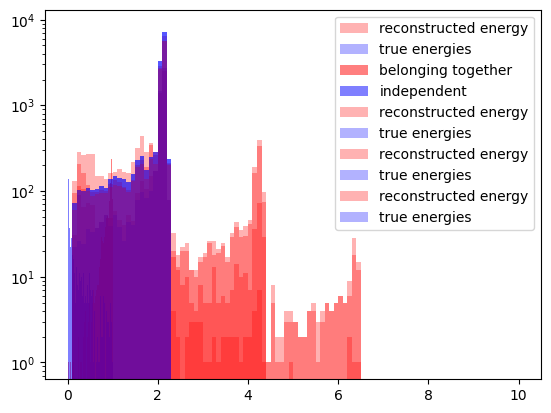

In [4]:
res_var1_2_1mev = var1_agglo_edge("./sim_data/data_2_1_mev/false_neg_2_1_mev.txt","./sim_data/data_2_1_mev/test_raw.txt")

Model's state_dict:
linear.weight 	 torch.Size([1000, 12])
linear.bias 	 torch.Size([1000])
another_linear.weight 	 torch.Size([100, 1000])
another_linear.bias 	 torch.Size([100])
another_linear_two.weight 	 torch.Size([100, 100])
another_linear_two.bias 	 torch.Size([100])
linear_back.weight 	 torch.Size([1, 100])
linear_back.bias 	 torch.Size([1])
epochnr: 0 0.0 %
epochnr: 1 0.01 %
epochnr: 2 0.02 %
epochnr: 3 0.03 %
epochnr: 4 0.04 %
epochnr: 5 0.05 %
epochnr: 6 0.06 %
epochnr: 7 0.06999999999999999 %
epochnr: 8 0.08 %
epochnr: 9 0.09 %
epochnr: 10 0.1 %
epochnr: 11 0.11 %
epochnr: 12 0.12 %
epochnr: 13 0.13 %
epochnr: 14 0.13999999999999999 %
epochnr: 15 0.15 %
epochnr: 16 0.16 %
epochnr: 17 0.16999999999999998 %
epochnr: 18 0.18 %
epochnr: 19 0.19 %
epochnr: 20 0.2 %
epochnr: 21 0.21 %
epochnr: 22 0.22 %
epochnr: 23 0.22999999999999998 %
epochnr: 24 0.24 %
epochnr: 25 0.25 %
epochnr: 26 0.26 %
epochnr: 27 0.27 %
epochnr: 28 0.27999999999999997 %
epochnr: 29 0.29 %
epochnr: 30 0.3 

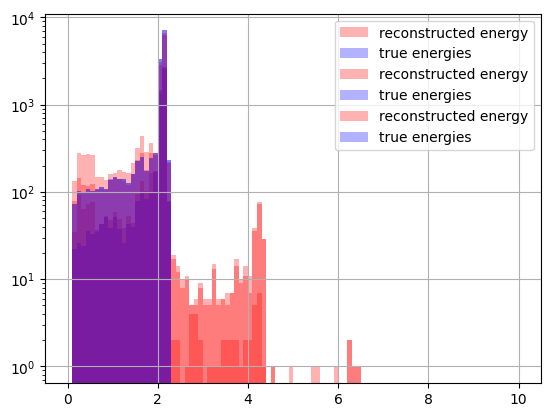

In [5]:
res_vas2_2_1mev = var2_agglo_edge("./sim_data/data_2_1_mev/false_neg_2_1_mev.txt","./sim_data/data_2_1_mev/test_raw.txt","./sim_data/data_2_1_mev/precluster_test.txt")

#### uniform data

Model's state_dict:
linear.weight 	 torch.Size([1000, 12])
linear.bias 	 torch.Size([1000])
another_linear.weight 	 torch.Size([100, 1000])
another_linear.bias 	 torch.Size([100])
another_linear_two.weight 	 torch.Size([100, 100])
another_linear_two.bias 	 torch.Size([100])
linear_back.weight 	 torch.Size([1, 100])
linear_back.bias 	 torch.Size([1])
epochnr: 0 0.0 %
epochnr: 1 0.01 %
epochnr: 2 0.02 %
epochnr: 3 0.03 %
epochnr: 4 0.04 %
epochnr: 5 0.05 %
epochnr: 6 0.06 %
epochnr: 7 0.06999999999999999 %
epochnr: 8 0.08 %
epochnr: 9 0.09 %
epochnr: 10 0.1 %
epochnr: 11 0.11 %
epochnr: 12 0.12 %
epochnr: 13 0.13 %
epochnr: 14 0.13999999999999999 %
epochnr: 15 0.15 %
epochnr: 16 0.16 %
epochnr: 17 0.16999999999999998 %
epochnr: 18 0.18 %
epochnr: 19 0.19 %
epochnr: 20 0.2 %
epochnr: 21 0.21 %
epochnr: 22 0.22 %
epochnr: 23 0.22999999999999998 %
epochnr: 24 0.24 %
epochnr: 25 0.25 %
epochnr: 26 0.26 %
epochnr: 27 0.27 %
epochnr: 28 0.27999999999999997 %
epochnr: 29 0.29 %
epochnr: 30 0.3 

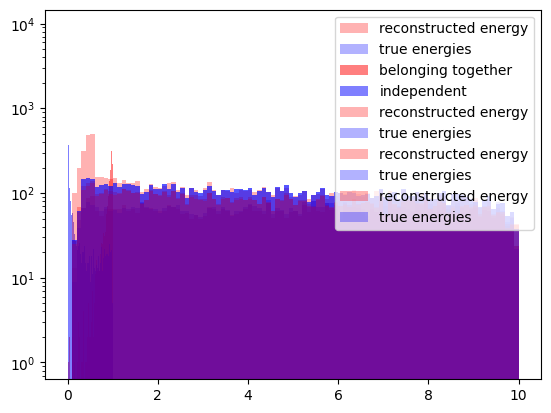

In [8]:
res_var1_uniform = var1_agglo_edge("./sim_data/data_uniform/false_neg_uniform.txt","./sim_data/data_uniform/data_raw_uniform_test.csv")

Model's state_dict:
linear.weight 	 torch.Size([1000, 12])
linear.bias 	 torch.Size([1000])
another_linear.weight 	 torch.Size([100, 1000])
another_linear.bias 	 torch.Size([100])
another_linear_two.weight 	 torch.Size([100, 100])
another_linear_two.bias 	 torch.Size([100])
linear_back.weight 	 torch.Size([1, 100])
linear_back.bias 	 torch.Size([1])
epochnr: 0 0.0 %
epochnr: 1 0.01 %
epochnr: 2 0.02 %
epochnr: 3 0.03 %
epochnr: 4 0.04 %
epochnr: 5 0.05 %
epochnr: 6 0.06 %
epochnr: 7 0.06999999999999999 %
epochnr: 8 0.08 %
epochnr: 9 0.09 %
epochnr: 10 0.1 %
epochnr: 11 0.11 %
epochnr: 12 0.12 %
epochnr: 13 0.13 %
epochnr: 14 0.13999999999999999 %
epochnr: 15 0.15 %
epochnr: 16 0.16 %
epochnr: 17 0.16999999999999998 %
epochnr: 18 0.18 %
epochnr: 19 0.19 %
epochnr: 20 0.2 %
epochnr: 21 0.21 %
epochnr: 22 0.22 %
epochnr: 23 0.22999999999999998 %
epochnr: 24 0.24 %
epochnr: 25 0.25 %
epochnr: 26 0.26 %
epochnr: 27 0.27 %
epochnr: 28 0.27999999999999997 %
epochnr: 29 0.29 %
epochnr: 30 0.3 

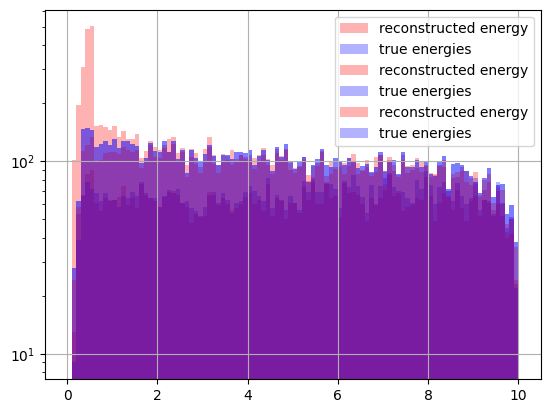

In [9]:
res_var2_uniform = var2_agglo_edge("./sim_data/data_uniform/false_neg_uniform.txt","./sim_data/data_uniform/data_raw_uniform_test.csv","./sim_data/data_uniform/precluster_test.txt")

### final uniform data

Model's state_dict:
linear.weight 	 torch.Size([1000, 12])
linear.bias 	 torch.Size([1000])
another_linear.weight 	 torch.Size([100, 1000])
another_linear.bias 	 torch.Size([100])
another_linear_two.weight 	 torch.Size([100, 100])
another_linear_two.bias 	 torch.Size([100])
linear_back.weight 	 torch.Size([1, 100])
linear_back.bias 	 torch.Size([1])
epochnr: 0 0.0 %
epochnr: 1 0.01 %
epochnr: 2 0.02 %
epochnr: 3 0.03 %
epochnr: 4 0.04 %
epochnr: 5 0.05 %
epochnr: 6 0.06 %
epochnr: 7 0.06999999999999999 %
epochnr: 8 0.08 %
epochnr: 9 0.09 %
epochnr: 10 0.1 %
epochnr: 11 0.11 %
epochnr: 12 0.12 %
epochnr: 13 0.13 %
epochnr: 14 0.13999999999999999 %
epochnr: 15 0.15 %
epochnr: 16 0.16 %
epochnr: 17 0.16999999999999998 %
epochnr: 18 0.18 %
epochnr: 19 0.19 %
epochnr: 20 0.2 %
epochnr: 21 0.21 %
epochnr: 22 0.22 %
epochnr: 23 0.22999999999999998 %
epochnr: 24 0.24 %
epochnr: 25 0.25 %
epochnr: 26 0.26 %
epochnr: 27 0.27 %
epochnr: 28 0.27999999999999997 %
epochnr: 29 0.29 %
epochnr: 30 0.3 

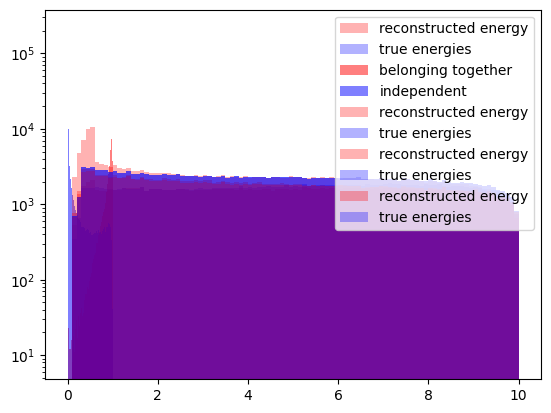

In [10]:
res_var1_uniform = var1_agglo_edge("./sim_data/data_final_uniform/false_neg_uniform_final.txt","./sim_data/data_final_uniform/final_uniform_test.txt")

Model's state_dict:
linear.weight 	 torch.Size([1000, 12])
linear.bias 	 torch.Size([1000])
another_linear.weight 	 torch.Size([100, 1000])
another_linear.bias 	 torch.Size([100])
another_linear_two.weight 	 torch.Size([100, 100])
another_linear_two.bias 	 torch.Size([100])
linear_back.weight 	 torch.Size([1, 100])
linear_back.bias 	 torch.Size([1])
epochnr: 0 0.0 %
epochnr: 1 0.01 %
epochnr: 2 0.02 %
epochnr: 3 0.03 %
epochnr: 4 0.04 %
epochnr: 5 0.05 %
epochnr: 6 0.06 %
epochnr: 7 0.06999999999999999 %
epochnr: 8 0.08 %
epochnr: 9 0.09 %
epochnr: 10 0.1 %
epochnr: 11 0.11 %
epochnr: 12 0.12 %
epochnr: 13 0.13 %
epochnr: 14 0.13999999999999999 %
epochnr: 15 0.15 %
epochnr: 16 0.16 %
epochnr: 17 0.16999999999999998 %
epochnr: 18 0.18 %
epochnr: 19 0.19 %
epochnr: 20 0.2 %
epochnr: 21 0.21 %
epochnr: 22 0.22 %
epochnr: 23 0.22999999999999998 %
epochnr: 24 0.24 %
epochnr: 25 0.25 %
epochnr: 26 0.26 %
epochnr: 27 0.27 %
epochnr: 28 0.27999999999999997 %
epochnr: 29 0.29 %
epochnr: 30 0.3 

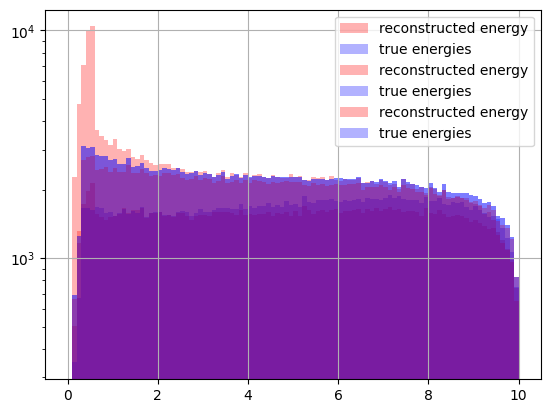

In [11]:
res_var2_uniform = var2_agglo_edge("./sim_data/data_final_uniform/false_neg_uniform_final.txt","./sim_data/data_final_uniform/final_uniform_test.txt","./sim_data/data_final_uniform/precluster_test.txt")

### r3b model only

continuous numbers: [     0      0      1 ... 219427 219428 219428]
(532437, 5)
[0.00000e+00 1.00000e+00 2.00000e+00 ... 2.19426e+05 2.19427e+05
 2.19428e+05]
something goes completely wrong!!!
angles phi1,2, theta1,2: 2.021229192888889 2.021229192888889 1.331397115361111 1.331397115361111
1.0000000000000002
something goes completely wrong!!!
angles phi1,2, theta1,2: 1.6294257960388887 1.6294257960388887 0.8135286931222222 0.8135286931222222
1.0000000000000002
something goes completely wrong!!!
angles phi1,2, theta1,2: 4.771010560055554 4.771010560055554 0.8135286931222222 0.8135286931222222
1.0000000000000002
something goes completely wrong!!!
angles phi1,2, theta1,2: 0.5326722924499999 0.5326722924499999 1.1901372663388887 1.1901372663388887
1.0000000000000002
something goes completely wrong!!!
angles phi1,2, theta1,2: 2.217299315444444 2.217299315444444 1.3774772593499998 1.3774772593499998
1.0000000000000002
something goes completely wrong!!!
angles phi1,2, theta1,2: 3.674264037777

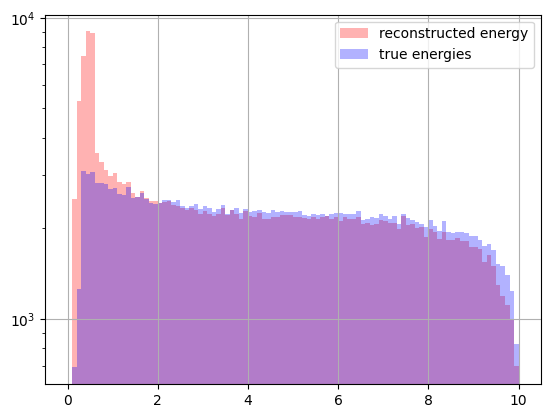

In [13]:
data = genfromtxt('./sim_data/data_final_uniform/final_uniform_test.txt',delimiter=',')
data[:,4] = 1  #this step is needed, I only want positive time values, so that I can use the time as a radius
# ### structure of mydata : eventnr, energy, theta, phi, hit-time
data = data*[1.,1.,3.14159/180,3.14159/180,1.]
unique_values, continuous_numbers = np.unique(data[:,0], return_inverse=True)
data[:,0] = continuous_numbers
print("continuous numbers:", continuous_numbers)
out_cluster_r3b = run_r3b_clustering(data,0.25)
#foo = plot_true_reco(data)
foo_comb = get_true_combinatorics(data)
foo_ene = get_true_reco_ene(data,out_cluster_r3b,foo_comb)

continuous numbers: [    0     0     0 ... 13498 13499 13499]
(26758, 5)
[0.0000e+00 1.0000e+00 2.0000e+00 ... 1.3497e+04 1.3498e+04 1.3499e+04]
well reco... 0.8582857989480702
---more statistics....---
fully true_reco_cluster:	 0.7184444444444444
false positive events:	 0.060444444444444446
false negative events:	 0.15866666666666668
mixed false events:	 0.06244444444444444
end of statistiscs------


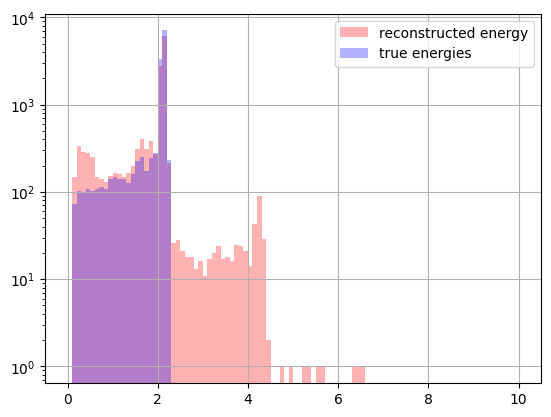

In [14]:
data = genfromtxt('./sim_data/data_2_1_mev/test_raw.txt',delimiter=',')
data[:,4] = 1  #this step is needed, I only want positive time values, so that I can use the time as a radius
# ### structure of mydata : eventnr, energy, theta, phi, hit-time
data = data*[1.,1.,3.14159/180,3.14159/180,1.]
unique_values, continuous_numbers = np.unique(data[:,0], return_inverse=True)
data[:,0] = continuous_numbers
print("continuous numbers:", continuous_numbers)
out_cluster_r3b = run_r3b_clustering(data,0.25)
#foo = plot_true_reco(data)
foo_comb = get_true_combinatorics(data)
foo_ene = get_true_reco_ene(data,out_cluster_r3b,foo_comb)

### agglo model only

219426
Progress: 0.00%
Progress: 1.37%
Progress: 2.73%
Progress: 4.10%
Progress: 5.47%
Progress: 6.84%
Progress: 8.20%
Progress: 9.57%
Progress: 10.94%
Progress: 12.30%
Progress: 13.67%
Progress: 15.04%
Progress: 16.41%
Progress: 17.77%
Progress: 19.14%
Progress: 20.51%
Progress: 21.87%
Progress: 23.24%
Progress: 24.61%
Progress: 25.98%
Progress: 27.34%
Progress: 28.71%
Progress: 30.08%
Progress: 31.45%
Progress: 32.81%
Progress: 34.18%
Progress: 35.55%
Progress: 36.91%
Progress: 38.28%
Progress: 39.65%
Progress: 41.02%
Progress: 42.38%
Progress: 43.75%
Progress: 45.12%
Progress: 46.48%
Progress: 47.85%
Progress: 49.22%
Progress: 50.59%
Progress: 51.95%
Progress: 53.32%
Progress: 54.69%
Progress: 56.05%
Progress: 57.42%
Progress: 58.79%
Progress: 60.16%
Progress: 61.52%
Progress: 62.89%
Progress: 64.26%
Progress: 65.62%
Progress: 66.99%
Progress: 68.36%
Progress: 69.73%
Progress: 71.09%
Progress: 72.46%
Progress: 73.83%
Progress: 75.20%
Progress: 76.56%
Progress: 77.93%
Progress: 79.30

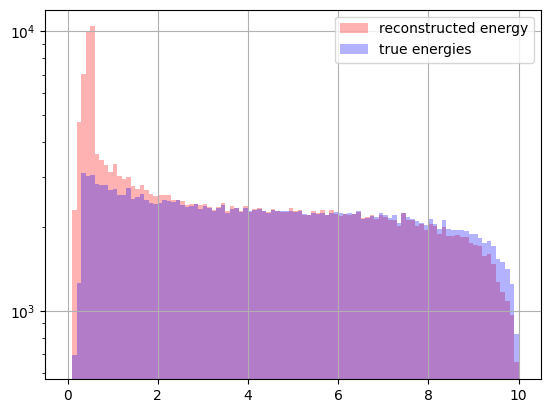

In [15]:
data = genfromtxt('./sim_data/data_final_uniform/final_uniform_test.txt', delimiter=',')
data[:,4] = data[:,4]+4500  #this step is needed, I only want positive time values, so that I can use the time as a radius
#my_data[:,4] = 1  #this step is needed, I only want positive time values, so that I can use the time as a radius

# ### structure of mydata : eventnr, energy, theta, phi, hit-time
data = data*[1.,1.,3.14159/180,3.14159/180,1.]
unique_values, continuous_numbers = np.unique(data[:,0], return_inverse=True)
data[:,0] = continuous_numbers
out_cluster_agglo = run_agglo_clustering(data,3540)
foo_comb = get_true_combinatorics(data)
foo_ene = get_true_reco_ene(data,out_cluster_agglo,foo_comb)

13497
Progress: 0.00%
Progress: 22.22%
Progress: 44.44%
Progress: 66.67%
Progress: 88.89%
well reco... 0.8912512037928736
---more statistics....---
fully true_reco_cluster:	 0.7602222222222222
false positive events:	 0.051111111111111114
false negative events:	 0.17044444444444445
mixed false events:	 0.018222222222222223
end of statistiscs------


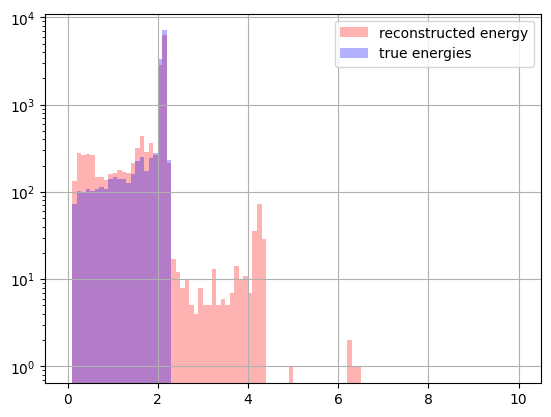

In [16]:
data = genfromtxt('./sim_data/data_2_1_mev/test_raw.txt', delimiter=',')
data[:,4] = data[:,4]+4500  #this step is needed, I only want positive time values, so that I can use the time as a radius
#my_data[:,4] = 1  #this step is needed, I only want positive time values, so that I can use the time as a radius

# ### structure of mydata : eventnr, energy, theta, phi, hit-time
data = data*[1.,1.,3.14159/180,3.14159/180,1.]
unique_values, continuous_numbers = np.unique(data[:,0], return_inverse=True)
data[:,0] = continuous_numbers
out_cluster_agglo = run_agglo_clustering(data,3540)
foo_comb = get_true_combinatorics(data)
foo_ene = get_true_reco_ene(data,out_cluster_agglo,foo_comb)

### edge model only with/without time

#### without time info -uniform data

In [ ]:
training_data = genfromtxt('./sim_data/data_final_uniform/final_uniform_validation.txt', delimiter=',')
print("training data read")
## some data manipulation needed
training_data[:,4] =(training_data[:,4]-np.min(training_data[:,4]))/(np.max(training_data[:,4])-np.min(training_data[:,4]))
unique_values, continuous_numbers = np.unique(training_data[:,0], return_inverse=True)
training_data[:,0] = continuous_numbers
training_data[:,2] = training_data[:,2]*math.pi/180.
training_data[:,3] = training_data[:,3]*math.pi/180.
training_data[:,4] = 1  ## set time to 1, not sensitive to time, TODO: remove later, just a test
training_true = get_true_combinatorics(training_data)
print("I start manipulating data...")
input_training_data = manip_data_ff(training_data,12) ##second param gives number of features
print("after input traingin def")
pred_training = train_two_hidden_model(input_training_data,torch.FloatTensor(training_true),12,1000,5e-3,100)
print("pred_training finished")
training_reco = get_true_reco_ene(training_data,pred_training[0].tolist(),training_true)


###testing
val_data = genfromtxt('./sim_data/data_final_uniform/final_uniform_test.txt', delimiter=',')
## some data manipulation needed
val_data[:,4] =(val_data[:,4]-np.min(val_data[:,4]))/(np.max(val_data[:,4])-np.min(val_data[:,4]))
unique_values, continuous_numbers = np.unique(val_data[:,0], return_inverse=True)
val_data[:,0] = continuous_numbers
val_data[:,2] = val_data[:,2]*math.pi/180.
val_data[:,3] = val_data[:,3]*math.pi/180.
val_data[:,4] = 1 ## set time to 1, not sensitive to time, TODO: remove later, just a test
val_true = get_true_combinatorics(val_data)
input_val_data = manip_data_ff(val_data,12) ##second param gives number of features

pred_val = validate_two_hidden_model(input_val_data,torch.FloatTensor(val_true),12,1000,5e-3,100)

val_reco = get_true_reco_ene(val_data,pred_val[0].tolist(),val_true)

training data read


#### with time info - uniform data

In [ ]:
training_data = genfromtxt('./sim_data/data_final_uniform/final_uniform_validation.txt', delimiter=',')
## some data manipulation needed
training_data[:,4] =(training_data[:,4]-np.min(training_data[:,4]))/(np.max(training_data[:,4])-np.min(training_data[:,4]))
unique_values, continuous_numbers = np.unique(training_data[:,0], return_inverse=True)
training_data[:,0] = continuous_numbers
training_data[:,2] = training_data[:,2]*math.pi/180.
training_data[:,3] = training_data[:,3]*math.pi/180.
#training_data[:,4] = 1  ## set time to 1, not sensitive to time, TODO: remove later, just a test
training_true = get_true_combinatorics(training_data)
input_training_data = manip_data_ff(training_data,12) ##second param gives number of features

pred_training = train_two_hidden_model(input_training_data,torch.FloatTensor(training_true),12,1000,5e-3,100)

training_reco = get_true_reco_ene(training_data,pred_training[0].tolist(),training_true)


###testing
val_data = genfromtxt('./sim_data/data_final_uniform/final_uniform_test.txt', delimiter=',')
## some data manipulation needed
val_data[:,4] =(val_data[:,4]-np.min(val_data[:,4]))/(np.max(val_data[:,4])-np.min(val_data[:,4]))
unique_values, continuous_numbers = np.unique(val_data[:,0], return_inverse=True)
val_data[:,0] = continuous_numbers
val_data[:,2] = val_data[:,2]*math.pi/180.
val_data[:,3] = val_data[:,3]*math.pi/180.
#val_data[:,4] = 1 ## set time to 1, not sensitive to time, TODO: remove later, just a test
val_true = get_true_combinatorics(val_data)
input_val_data = manip_data_ff(val_data,12) ##second param gives number of features

pred_val = validate_two_hidden_model(input_val_data,torch.FloatTensor(val_true),12,1000,5e-3,100)

val_reco = get_true_reco_ene(val_data,pred_val[0].tolist(),val_true)